# Solar PV Power Forecasting - A DRE (DestinE Use Case) derived paradigm
## Using Historical CAMS Data and ECMWF DT Forecasts

**Learning Objectives:**
1. Load and explore actual CAMS historical solar radiation timeseries data
2. Perform EDA: normalization, correlation analysis, feature engineering
3. Simulate actual PV park power production data (target variable)
4. Process ECMWF GRIB forecast files (SSRD for next 2 days)
5. Build solar power regression models for 2-day forecasting:
   - Neural Network (simple)
   - XGBoost
6. Compare and evaluate all approaches

---

**Estimated time:** 1 hour

---

## Part 1: Setup and Installation

In [ ]:
# Install required packages
!pip install pandas numpy matplotlib seaborn plotly scikit-learn xgboost tensorflow cfgrib xarray --quiet

import warnings
warnings.filterwarnings('ignore')

print("✓ Setup complete!")

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta

# ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# GRIB file handling
import xarray as xr
import cfgrib

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Load Historical CAMS Data

### 📝 Load and inspect CAMS historical data

Load 5-year historical CAMS data provided. The data should contain:
- Observation period (ISO 8601)
- TOA. Irradiation on horizontal plane at the top of atmosphere (Wh/m2)
- Clear sky GHI. Clear sky global irradiation on horizontal plane at ground level
(Wh/m2)
- Clear sky BHI. Clear sky beam irradiation on horizontal plane at ground level
(Wh/m2)
- Clear sky DHI. Clear sky diffuse irradiation on horizontal plane at ground level
(Wh/m2)
- Clear sky BNI. Clear sky beam irradiation on mobile plane following the sun at
normal incidence (Wh/m2) <br>
- GHI. Global irradiation on horizontal plane at ground level (Wh/m2) <br>
-> Global Horizontal Irradiance, is the total amount of solar radiation (sunlight) hitting a flat, horizontal surface on Earth
- BHI. Beam irradiation on horizontal plane at ground level (Wh/m2) <br>
-> Beam Horizontal Irradiance is the direct sunlight component hitting a flat, horizontal surface.
- DHI. Diffuse irradiation on horizontal plane at ground level (Wh/m2)
-> Diffuse Horizontal Irradiance, is the portion of solar radiation that reaches Earth's surface after being scattered (or diffused) by the atmosphere, <br>
arriving from all directions rather than directly from the sun's disk! 
<br> It's also being measured on a horizontal surface where it complements Direct Normal Irradiance (DNI) to form Global Horizontal Irradiance
- BNI. Beam irradiation on mobile plane following the sun at normal incidence (Wh/m2)
-> also referred to as DNI – Direct Normal Irradiance, is the amount of direct solar radiation received on a surface that is perpendicular (normal) to the Sun’s rays. 
- Reliability. Proportion of reliable data in the summarization (0-1)

Horizontal vs. Normal irradiation refers to how solar energy hits a surface: Horizontal (like Global Horizontal Irradiance, GHI)   <br>
measures total energy on a flat ground (direct + scattered), while Normal (Direct Normal Irradiance, DNI) measures intense, direct <br>
sunlight hitting a surface perpendicular to the sun's rays, crucial for concentrated solar power (CSP). The key difference is the <br>
surface orientation and the type of radiation: GHI is for general PV, DNI for focusing systems, and Diffuse Horizontal (DHI) is <br>
scattered light on a horizontal plane

In [ ]:
#BHI=BNI×cos(θz) where θz θz is the solar zenith angle.
# At solar noon: If the Sun is directly overhead (θz=0∘, e.g., at the equator on an equinox), then BHI = BNI.
# At any other location or time, θz>0∘, so BHI < BNI, even at noon.
import math

BNI = 800  # W/m² (direct normal irradiance)

for zenith_deg in [0, 30]:
    BHI = BNI * math.cos(math.radians(zenith_deg))
    print(f"Zenith {zenith_deg}° → BHI = {BHI:.1f} W/m²")
#


Zenith 0° → BHI = 800.0 W/m²
Zenith 30° → BHI = 692.8 W/m²


CAMS solar radiation time-series data provides historical (2004-present) global, direct, and diffuse solar irradiance (GHI, BHI, DHI) for energy planning, using satellite data and atmospheric models for detailed forecasts, accessible globally but with higher resolution cloud data in MSG/Himawari satellite footprints (Europe, Africa, Asia, etc.). Users can download this data in formats like NetCDF or CSV, selecting specific locations, dates, and time steps

For clear-sky conditions, an irradiation time series is provided for any location in the world! 
Similar time series are available for cloudy (or “all sky”) conditions but, since the high-resolution cloud information 
is directly inferred from satellite observations, these are currently only available inside the field-of-view of the Meteosat Second Generation (MSG) and the Himawari satellites, which is roughly Europe, Africa, part of South America, the Atlantic Ocean, the Middle East, part of Asia, and Australia.

Read more: https://ads.atmosphere.copernicus.eu/datasets/cams-solar-radiation-timeseries?tab=overview

In [77]:
CAMS_DATA_PATH = "cams_sample.csv"  # replace with your actual path

In [ ]:
# --- Load a CAMS CSV where the first lines are comments starting with '#' ---
#read and display comment lines

header = []
with open(CAMS_DATA_PATH, "r", encoding="utf-8") as f:
    for line in f:
        if line.startswith("#"):
            header.append(line[1:].rstrip())  # remove '#'
        else:
            break

display(Markdown("```\n" + "\n".join(header) + "\n```"))


```
 Coding: utf-8
 File format version: 2
 Title: CAMS Radiation Service v4.6 all-sky irradiation (derived from satellite data).
 Content:  A time-series of solar radiation received on horizontal plane and plane always normal to the sun rays at ground level.
           Returns the global, beam and diffuse irradiations integrated over a selected time step,
           for a selected location (geostationary satellite coverage) and a selected period.
 The research leading to these results has received funding from the European Union within the Copernicus programme.
 Provider: VAISALA with MINES ParisTech (France) and DLR (Germany)
 More information at: http://www.soda-pro.com/web-services/radiation/cams-radiation-service
 Date begin (ISO 8601): 2020-12-06T00:00:00.0
 Date end (ISO 8601): 2025-12-07T00:00:00.0
 Latitude (positive North, ISO 19115): 30.1547
 Longitude (positive East, ISO 19115): 20.4646
 Altitude (m): 32.00
 Time reference: Universal time (UT)

 Encoding partly from D2.8.III.13-14 INSPIRE Data Specification on Atmospheric Conditions and Meteorological Geographical Features - Technical Guidelines (2013-12-10) and CF (Climate and Forecast) metadata (2013-11-11)
 CF Standard Names registry of ObservablePropertyValue
 http://cfconventions.org/Data/cf-standard-names/27/build/cf-standard-name-table.html
 urn:x-inspire:specification:DS-AC-MF:observable-property-name:cf-standard-name:1.6
 ObservableProperty
     basePhenomenon:"integral_of_surface_downwelling_shortwave_flux_in_air_sky_wrt_time"
     uom:"Wh m-2" [unit]
 StatisticalMeasure
     statisticalFunction: "sum"
 Summarization (integration) period: 0 year 0 month 0 day 1 h 0 min 0 s
 noValue: nan
 File generated on: 2025-12-08

 Columns:
 1. Observation period (ISO 8601)
 2. TOA. Irradiation on horizontal plane at the top of atmosphere (Wh/m2)
 3. Clear sky GHI. Clear sky global irradiation on horizontal plane at ground level (Wh/m2)
 4. Clear sky BHI. Clear sky beam irradiation on horizontal plane at ground level (Wh/m2)
 5. Clear sky DHI. Clear sky diffuse irradiation on horizontal plane at ground level (Wh/m2)
 6. Clear sky BNI. Clear sky beam irradiation on mobile plane following the sun at normal incidence (Wh/m2)
 7. GHI. Global irradiation on horizontal plane at ground level (Wh/m2)
 8. BHI. Beam irradiation on horizontal plane at ground level (Wh/m2)
 9. DHI. Diffuse irradiation on horizontal plane at ground level (Wh/m2)
10. BNI. Beam irradiation on mobile plane following the sun at normal incidence (Wh/m2)
11. Reliability. Proportion of reliable data in the summarization (0-1)

 Observation period;TOA;Clear sky GHI;Clear sky BHI;Clear sky DHI;Clear sky BNI;GHI;BHI;DHI;BNI;Reliability
```

In [80]:
df = pd.read_csv("cams_sample.csv", sep=";", comment="#")

#Is the data loaded correctly?
df.head()


,2020-12-06T00:00:00.0/2020-12-06T01:00:00.0,0.0000,0.0000.1,0.0000.2,0.0000.3,0.0000.4,0.0000.5,0.0000.6,0.0000.7,0.0000.8,1.0000
0,2020-12-06T01:00:00.0/2020-12-06T02:00:00.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,2020-12-06T02:00:00.0/2020-12-06T03:00:00.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,2020-12-06T03:00:00.0/2020-12-06T04:00:00.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3,2020-12-06T04:00:00.0/2020-12-06T05:00:00.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
4,2020-12-06T05:00:00.0/2020-12-06T06:00:00.0,47.491,15.6809,1.3124,14.3685,14.3362,15.6809,1.3124,14.3685,14.3362,0.7167


In [85]:
# TODO Try and load the dataset into a Pandas DataFrame
#Hint: the last commented line contains the header/column names

In [83]:
with open(CAMS_DATA_PATH, "r", encoding="utf-8") as f:
    n_skip = sum(1 for line in f if line.startswith("#"))

df = pd.read_csv(
    CAMS_DATA_PATH,
    sep=";",
    skiprows=n_skip
)

df.head()


,2020-12-06T00:00:00.0/2020-12-06T01:00:00.0,0.0000,0.0000.1,0.0000.2,0.0000.3,0.0000.4,0.0000.5,0.0000.6,0.0000.7,0.0000.8,1.0000
0,2020-12-06T01:00:00.0/2020-12-06T02:00:00.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,2020-12-06T02:00:00.0/2020-12-06T03:00:00.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
2,2020-12-06T03:00:00.0/2020-12-06T04:00:00.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3,2020-12-06T04:00:00.0/2020-12-06T05:00:00.0,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
4,2020-12-06T05:00:00.0/2020-12-06T06:00:00.0,47.491,15.6809,1.3124,14.3685,14.3362,15.6809,1.3124,14.3685,14.3362,0.7167


In [84]:
#One solution is to first read the file to find the header line, then load the CSV using that header.

header_line = 0
with open(CAMS_DATA_PATH, "r") as f:
    for i, line in enumerate(f):
        if line.startswith("#"):
            header_line = line.strip("#").strip()
            header_index = i

            # keep updating so we end up with the *last* comment line
        else:
            break  # first non-comment line → header is the previous one
# Use ; as the delimiter to extract column names
    column_names = [col.strip() for col in header_line.split(";")]

# Now load the CSV using that line as the header row.
data_start = header_index + 1
cams_historical = pd.read_csv(CAMS_DATA_PATH, skiprows=data_start, names=column_names, sep=";")

print("Detected header at line:", header_line)
print("Preview of the dataset:")
display(cams_historical.head())

Detected header at line: Observation period;TOA;Clear sky GHI;Clear sky BHI;Clear sky DHI;Clear sky BNI;GHI;BHI;DHI;BNI;Reliability
Preview of the dataset:


,Observation period,TOA,Clear sky GHI,Clear sky BHI,Clear sky DHI,Clear sky BNI,GHI,BHI,DHI,BNI,Reliability
0,2020-12-06T00:00:00.0/2020-12-06T01:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-12-06T01:00:00.0/2020-12-06T02:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2020-12-06T02:00:00.0/2020-12-06T03:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2020-12-06T03:00:00.0/2020-12-06T04:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2020-12-06T04:00:00.0/2020-12-06T05:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Exploratory Data Analysis (EDA)

### 📝 Basic statistical analysis

In [ ]:

# TODO: Display basic information:
#What's the shape of the data (rows, columns)?
#What is the date range covered by the data?    
#What are the column names of the dataset?
#Are there any missing values?
#Print basic info about the dataset


In [88]:
print(f"Data shape: {cams_historical.shape}")
print(f"\nColumns: {list(cams_historical.columns)}")
print(f"Date range: {cams_historical['Observation period'].min()} to {cams_historical['Observation period'].max()}")
print(f"\nFirst few rows:")
cams_historical.head()

Data shape: (43848, 11)

Columns: ['Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI', 'Reliability']
Date range: 2020-12-06T00:00:00.0/2020-12-06T01:00:00.0 to 2025-12-06T23:00:00.0/2025-12-07T00:00:00.0

First few rows:


,Observation period,TOA,Clear sky GHI,Clear sky BHI,Clear sky DHI,Clear sky BNI,GHI,BHI,DHI,BNI,Reliability
0,2020-12-06T00:00:00.0/2020-12-06T01:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-12-06T01:00:00.0/2020-12-06T02:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2020-12-06T02:00:00.0/2020-12-06T03:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2020-12-06T03:00:00.0/2020-12-06T04:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2020-12-06T04:00:00.0/2020-12-06T05:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#isnull return True for: np.nan, None, NaT
print(f"\nMissing values:\n{cams_historical.isnull().sum()}")
cams_historical.info()


Missing values:
Observation period    0
TOA                   0
Clear sky GHI         0
Clear sky BHI         0
Clear sky DHI         0
Clear sky BNI         0
GHI                   0
BHI                   0
DHI                   0
BNI                   0
Reliability           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Observation period  43848 non-null  object 
 1   TOA                 43848 non-null  float64
 2   Clear sky GHI       43848 non-null  float64
 3   Clear sky BHI       43848 non-null  float64
 4   Clear sky DHI       43848 non-null  float64
 5   Clear sky BNI       43848 non-null  float64
 6   GHI                 43848 non-null  float64
 7   BHI                 43848 non-null  float64
 8   DHI                 43848 non-null  float64
 9   BNI                 43848 non-null  float64
 10  Reli

In [ ]:
# Run this cell for total descriptive statistics and data quality check
print("=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)
display(cams_historical.describe())

print("\n" + "=" * 80)
print("DATA QUALITY CHECK")
print("=" * 80)

# Missing values
missing = cams_historical.isnull().sum()
missing_pct = (missing / len(cams_historical)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print("\nMissing Values:")
print(missing_df[missing_df['Missing Count'] > 0])

# Check for negative irradiance values (physically impossible)
irradiance_cols = [col for col in cams_historical.columns if any(x in col.lower() for x in ['ghi', 'dni', 'bni', 'dhi'])]
print(f"\nNegative Irradiance Values Check:")
for col in irradiance_cols:
    neg_count = (cams_historical[col] < 0).sum()
    if neg_count > 0:
        print(f"  {col}: {neg_count} negative values ({neg_count/len(cams_historical)*100:.2f}%)")
    else:
        print(f"  {col}: ✓ No negative values")
print("\n✓ EDA statistics computed")

DESCRIPTIVE STATISTICS


,TOA,Clear sky GHI,Clear sky BHI,Clear sky DHI,Clear sky BNI,GHI,BHI,DHI,BNI,Reliability
count,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000
mean,364.914718,267.231341,189.370113,77.861228,297.842252,246.800238,163.996806,82.803431,248.881341,0.982291
std,447.212708,345.442050,261.879015,97.895731,349.647601,333.084767,253.210149,106.466998,333.434429,0.057937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,41.243850,13.574250,1.840300,11.124050,22.953200,9.631100,0.197400,8.593250,2.051350,1.000000
75%,773.845175,559.765800,384.680675,146.922500,666.741800,493.498650,295.620950,154.826975,569.235200,1.000000
max,1307.819500,1104.336200,972.099600,554.655500,1020.854200,1104.336200,972.099600,568.423400,1020.854200,1.000000



DATA QUALITY CHECK

Missing Values:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

Negative Irradiance Values Check:
  Clear sky GHI: ✓ No negative values
  Clear sky DHI: ✓ No negative values
  Clear sky BNI: ✓ No negative values
  GHI: ✓ No negative values
  DHI: ✓ No negative values
  BNI: ✓ No negative values

✓ EDA statistics computed


### 📝 Visualize solar radiation patterns

In [ ]:
# TODO: Create a time series plot of GHI over a sample period (e.g., one month)
# Hint: Select a subset like cams_historical.loc['2023-06']

# TODO: Create subplots showing GHI, DNI/BNI, and DHI and the according Clear-sky values over the same period
# Compare the actual vs. clear-sky irradiance to see how weather affects solar radiation

#Hint: The actual timestamp column is 'Observation period', which format is like '2020-12-06T00:00:00.0/2020-12-06T01:00:00.0'

In [91]:
# Extract start time and set as index
cams_historical["time"] = pd.to_datetime(
    cams_historical["Observation period"].str.split("/").str[0]
)
cams_historical = cams_historical.set_index("time")

In [92]:
june_2023 = cams_historical.loc["2023-06"]


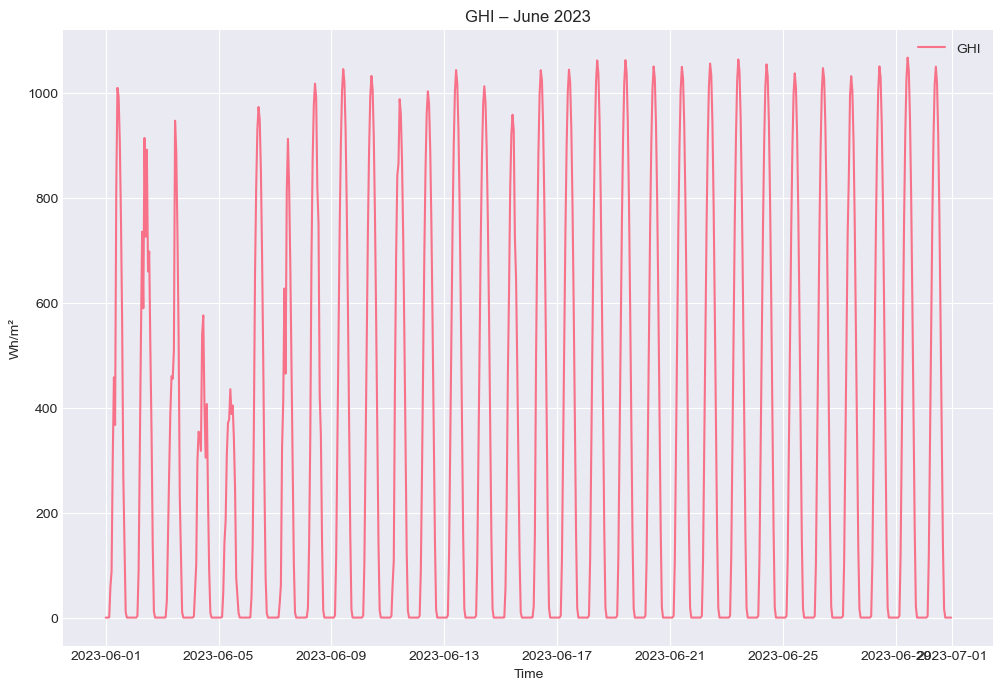

In [98]:
plt.figure(figsize=(12, 8))
plt.plot(june_2023.index, june_2023["GHI"], label="GHI")
plt.title("GHI – June 2023")
plt.xlabel("Time")
plt.ylabel("Wh/m²")
plt.legend()
plt.show()


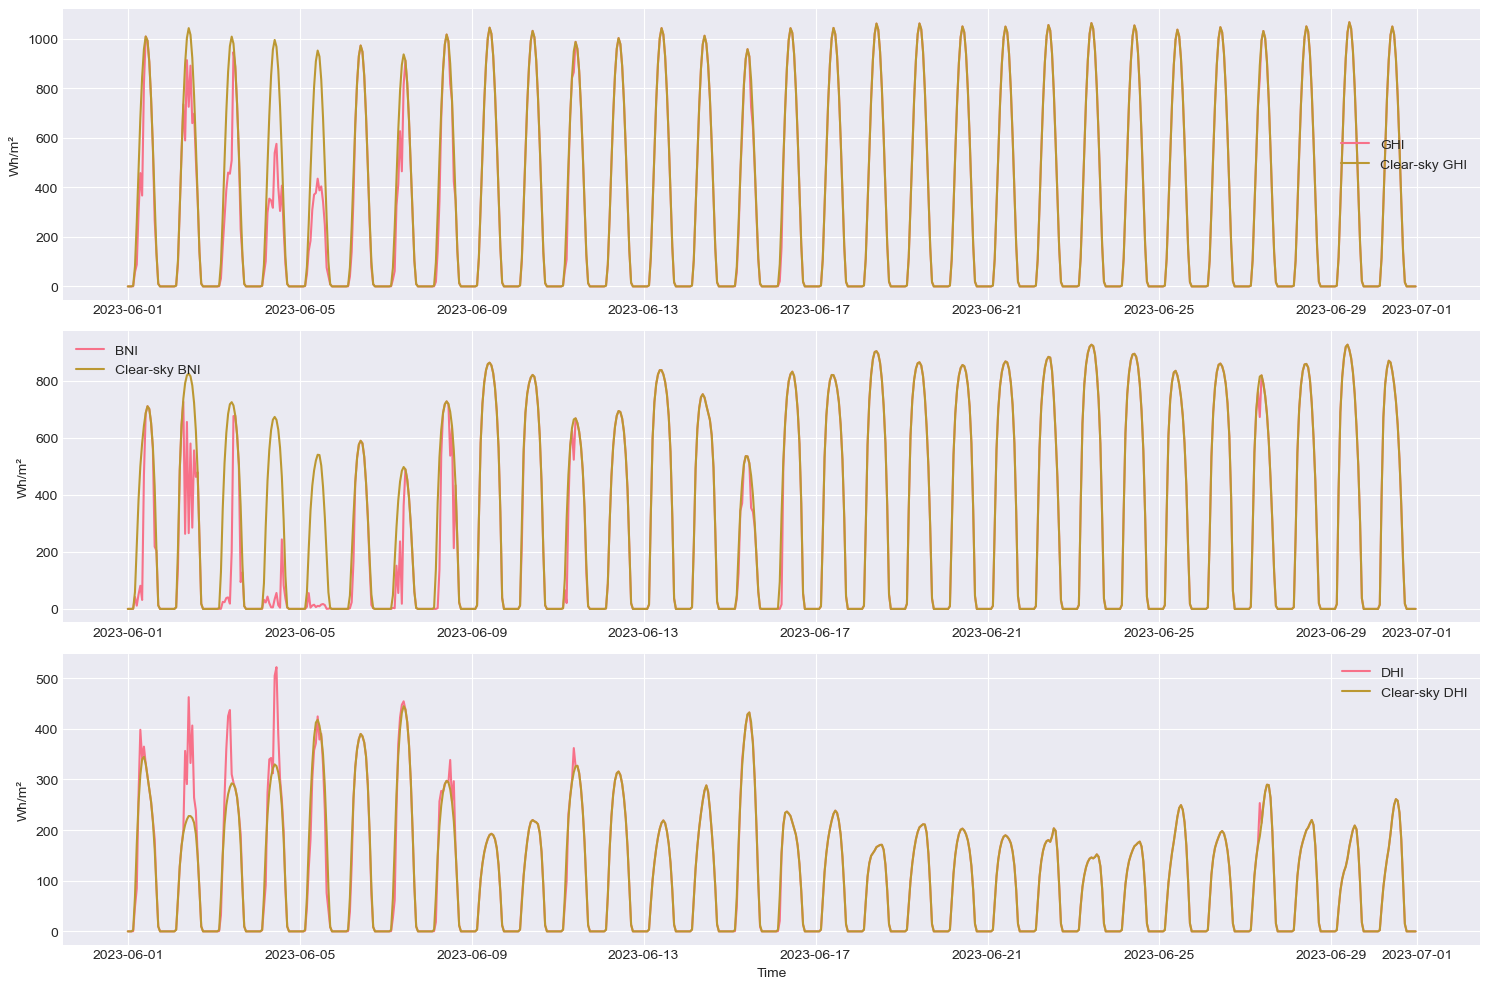

In [96]:
plt.figure(figsize=(15, 10))

# GHI
plt.subplot(3, 1, 1)
plt.plot(june_2023.index, june_2023["GHI"], label="GHI")
plt.plot(june_2023.index, june_2023["Clear sky GHI"], label="Clear-sky GHI")
plt.ylabel("Wh/m²")
plt.legend()

# BNI (DNI equivalent)
plt.subplot(3, 1, 2)
plt.plot(june_2023.index, june_2023["BNI"], label="BNI")
plt.plot(june_2023.index, june_2023["Clear sky BNI"], label="Clear-sky BNI")
plt.ylabel("Wh/m²")
plt.legend()

# DHI
plt.subplot(3, 1, 3)
plt.plot(june_2023.index, june_2023["DHI"], label="DHI")
plt.plot(june_2023.index, june_2023["Clear sky DHI"], label="Clear-sky DHI")
plt.xlabel("Time")
plt.ylabel("Wh/m²")
plt.legend()

plt.tight_layout()
plt.show()


# What do you observe about the differences between actual and clear-sky irradiance?

Clear-sky DHI represents diffuse radiation with no clouds, only molecular (Rayleigh) scattering and aerosols.

Under cloudy or partly cloudy conditions:

Clouds scatter sunlight strongly

Direct beam (BNI/DNI) drops

Diffuse radiation increases, sometimes well above clear-sky values
Diffuse light comes from all directions, and clouds are very effective at producing it.

### 📝 Correlation analysis

In terms of feature engineering and machine learning, the correlation between the variables is crucial for model feature selection

In [ ]:
# TODO: Calculate correlation matrix for all numerical features

# TODO: Create a heatmap using seaborn
# Hint: sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')

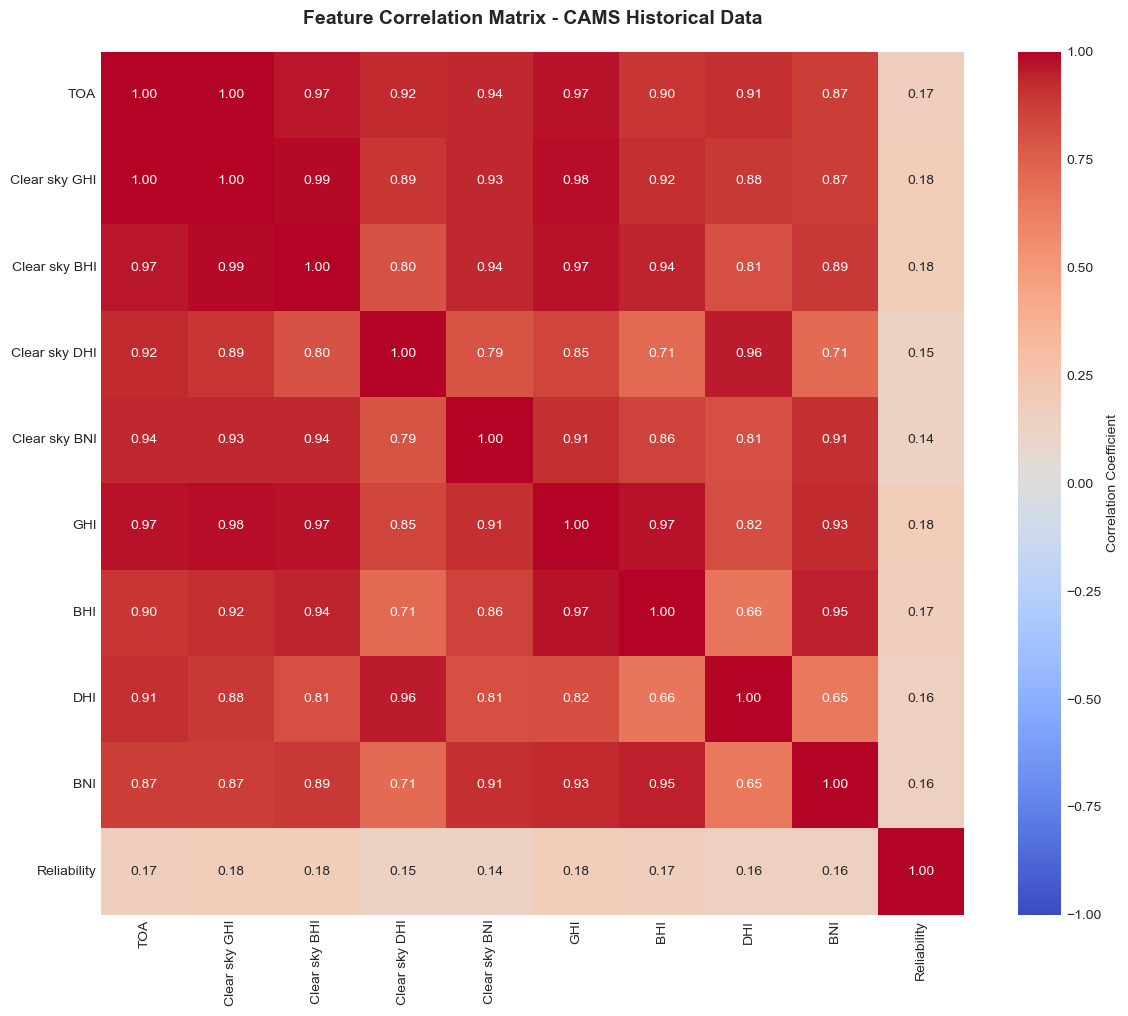


Highly Correlated Features (|correlation| > 0.9):


TypeError: 'int' object is not callable

In [166]:
# SOLUTION
# Calculate correlation matrix
#correlation_matrix = cams_historical.corr()
correlation_matrix = cams_historical.select_dtypes(include='number').corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, ax=ax,
            cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Feature Correlation Matrix - CAMS Historical Data', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print highly correlated pairs
print("\nHighly Correlated Features (|correlation| > 0.9):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            print(f"  {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

print("\n✓ Correlation analysis complete")

Whould you include all of these variables in a model?

### 📝 Data normalization and feature scaling

Prepare the data for machine learning by normalizing features.

In [100]:
# TODO: Create a copy of the data for processing
cams_processed = None  # TODO

# TODO: Handle missing values (if any)
# Options: forward fill, interpolation, drop

# TODO: Clip negative values to zero for irradiance columns

# TODO: Create StandardScaler and MinMaxScaler for later use
scaler_standard = None  # TODO
scaler_minmax = None  # TODO

In [101]:
# SOLUTION
# Create a copy
cams_processed = cams_historical.copy()

# Handle missing values with forward fill (preserves temporal patterns)
cams_processed.fillna(method='ffill', inplace=True)
# If still missing, backward fill
cams_processed.fillna(method='bfill', inplace=True)

# Clip negative irradiance values to zero (physically impossible)
irradiance_cols = [col for col in cams_processed.columns if any(x in col.lower() for x in ['ghi', 'dni', 'bni', 'dhi'])]
for col in irradiance_cols:
    cams_processed[col] = cams_processed[col].clip(lower=0)
    
print(f"✓ Missing values handled: {cams_processed.isnull().sum().sum()} remaining")
print(f"✓ Negative irradiance values clipped to zero")

# Initialize scalers (we'll fit them later with training data)
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

print("\n✓ Data preprocessing complete")
print(f"Processed data shape: {cams_processed.shape}")

✓ Missing values handled: 0 remaining
✓ Negative irradiance values clipped to zero

✓ Data preprocessing complete
Processed data shape: (43848, 11)


C:\Users\ageor\AppData\Local\Temp\ipykernel_24140\850274402.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cams_processed.fillna(method='ffill', inplace=True)
C:\Users\ageor\AppData\Local\Temp\ipykernel_24140\850274402.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cams_processed.fillna(method='bfill', inplace=True)


## Load Power Production Data (Target Variable)

### 📝 Load/Simulate historical power production

Load the actual power production data from the PV park. This is our target variable for training.

In [102]:
# TODO : Simulate power production data, that matches the CAMS historical data timestamps

In [104]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate 5 years of hourly timestamps
start_date = pd.to_datetime(cams_historical['Observation period'].min().split("/")[0])
end_date = pd.to_datetime(cams_historical['Observation period'].max().split("/")[0])
timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

# Helper function to generate realistic solar pattern
def generate_solar_pattern(timestamps):
    """Generate realistic diurnal solar radiation pattern"""
    hours = timestamps.hour
    days_of_year = timestamps.dayofyear
    
    # Solar elevation angle approximation
    # Peak at noon (hour 12), zero at night
    hour_angle = (hours - 12) / 6  # Normalized to [-2, 2]
    solar_elevation = np.maximum(0, np.cos(hour_angle * np.pi / 2))
    
    # Seasonal variation (higher in summer)
    seasonal_factor = 0.7 + 0.3 * np.sin(2 * np.pi * (days_of_year - 80) / 365)
    
    # Combine patterns
    base_pattern = solar_elevation * seasonal_factor
    
    return base_pattern

# Generate solar pattern
solar_pattern = generate_solar_pattern(timestamps)

# Create power production data matching your format (in kW)
print("\nGenerating power production data...")

# Assume a solar park with specific capacity
# For example: 10 MW = 10,000 kW capacity
park_capacity_kw = 10000  # Adjust this to match your park size

# Power follows GHI pattern with efficiency
# Using typical conversion: peak power occurs around 800-1000 W/m² GHI
# At 1000 W/m², park produces near capacity (with losses)
efficiency_factor = 0.85  # System efficiency + losses

# Calculate power in kW
# Scale: GHI (W/m²) / 1000 * capacity * efficiency
base_power_kw = (cams_historical['GHI'] / 1000) * park_capacity_kw * efficiency_factor

# Add (kind of) realistic variations and noise
weather_variation = 0.9 + 0.2 * np.random.random(len(timestamps))
noise = np.random.normal(0, park_capacity_kw * 0.01, len(timestamps))  # ±1% noise

power_production = pd.DataFrame({
    'timestamp': timestamps,
    'power_kw': np.maximum(0, base_power_kw * weather_variation + noise)
})

print(f"✓ Power production data generated: {len(power_production):,} records")
print(f"  Park capacity: {park_capacity_kw:,} kW ({park_capacity_kw/1000:.1f} MW)")
print(f"\nSample power production pattern (first 50 hours):")
print(power_production.head(50).to_string(index=True))

# Display statistics

print("\nPower Production Data (kW):")
print(power_production['power_kw'].describe())
print(f"\nPeak power: {power_production['power_kw'].max():.2f} kW")

print("\n✓ Synthetic data generation complete!")
print("You can now proceed with the rest of the notebook using 'cams_historical' and 'power_production'")


Generating power production data...
✓ Power production data generated: 43,848 records
  Park capacity: 10,000 kW (10.0 MW)

Sample power production pattern (first 50 hours):
                              timestamp     power_kw
time                                                
2020-12-06 00:00:00 2020-12-06 00:00:00     0.000000
2020-12-06 01:00:00 2020-12-06 01:00:00     0.000000
2020-12-06 02:00:00 2020-12-06 02:00:00     0.000000
2020-12-06 03:00:00 2020-12-06 03:00:00    91.421300
2020-12-06 04:00:00 2020-12-06 04:00:00     0.000000
2020-12-06 05:00:00 2020-12-06 05:00:00     0.000000
2020-12-06 06:00:00 2020-12-06 06:00:00  1079.970463
2020-12-06 07:00:00 2020-12-06 07:00:00  3112.846237
2020-12-06 08:00:00 2020-12-06 08:00:00  4198.120431
2020-12-06 09:00:00 2020-12-06 09:00:00  5239.848694
2020-12-06 10:00:00 2020-12-06 10:00:00  4704.186729
2020-12-06 11:00:00 2020-12-06 11:00:00  4830.063462
2020-12-06 12:00:00 2020-12-06 12:00:00  3819.583571
2020-12-06 13:00:00 2020-12-06

C:\Users\ageor\AppData\Local\Temp\ipykernel_24140\4161662099.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=start_date, end=end_date, freq='H')


Power production data shape: (43848, 2)
Date range: 2020-12-06 00:00:00 to 2025-12-06 23:00:00
Power column: time
2020-12-06 00:00:00      0.000000
2020-12-06 01:00:00      0.000000
2020-12-06 02:00:00      0.000000
2020-12-06 03:00:00     91.421300
2020-12-06 04:00:00      0.000000
                          ...    
2025-12-06 19:00:00     83.060074
2025-12-06 20:00:00    128.311075
2025-12-06 21:00:00     30.480564
2025-12-06 22:00:00     43.324489
2025-12-06 23:00:00     11.850306
Name: power_kw, Length: 43848, dtype: float64

Statistics:
count    43848.000000
mean      2116.890506
std       2824.434626
min          0.000000
25%          1.278428
50%        183.665853
75%       4169.690563
max      10073.956269
Name: power_kw, dtype: float64
edw:                               timestamp    power_kw
time                                               
2023-07-01 00:00:00 2023-07-01 00:00:00    0.000000
2023-07-01 01:00:00 2023-07-01 01:00:00    3.638636
2023-07-01 02:00:00 2023-07-01 02

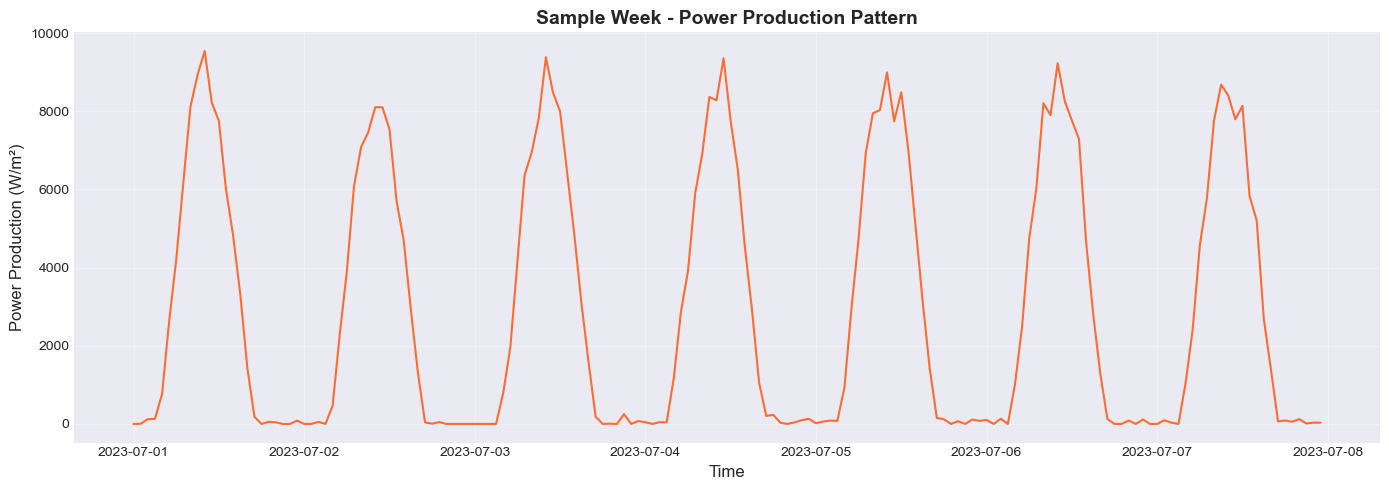


✓ Power production data loaded and visualized


In [105]:
# SOLUTION

print(f"Power production data shape: {power_production.shape}")
print(f"Date range: {power_production.timestamp.min()} to {power_production.timestamp.max()}")
print(f"Power column: {power_production['power_kw']}")
print(f"\nStatistics:")
print(power_production['power_kw'].describe())

# Visualize power production
ts = power_production['timestamp'].values.astype('datetime64[ns]')
start_idx = ts.searchsorted(np.datetime64('2023-07-01'))
end_idx = ts.searchsorted(np.datetime64('2023-07-08'))  # exclusive
sample_week = power_production.iloc[start_idx:end_idx]
#sample_week = power_production.iloc['2023-06-01':'2023-07-07']
print("edw:", sample_week)
plt.figure(figsize=(14, 5))
plt.plot(sample_week['timestamp'], sample_week['power_kw'], linewidth=1.5, color='#FF6B35')
plt.ylabel('Power Production (W/m²)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('Sample Week - Power Production Pattern', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Power production data loaded and visualized")

### 📝 Merge CAMS data with power production

Create a unified dataset for training.

In [106]:
# TODO: Merge CAMS data with power production on timestamp
# Hint: Use pd.merge or join operation

training_data = None  # TODO

# TODO: Remove any remaining NaN values

In [107]:
# SOLUTION
# Merge CAMS features with power production target
training_data = cams_historical.join(power_production, how='inner')

# Drop any remaining NaN values
print(f"Before dropping NaN: {training_data.shape}")
training_data.dropna(inplace=True)
print(f"After dropping NaN: {training_data.shape}")

print(f"\nTraining data ready!")
print(f"Date range: {training_data.index.min()} to {training_data.index.max()}")
print(f"Total samples: {len(training_data):,} hours")


display(training_data.head())
print("\n✓ Training data merged successfully")

Before dropping NaN: (43848, 13)
After dropping NaN: (43848, 13)

Training data ready!
Date range: 2020-12-06 00:00:00 to 2025-12-06 23:00:00
Total samples: 43,848 hours


,Observation period,TOA,Clear sky GHI,Clear sky BHI,Clear sky DHI,Clear sky BNI,GHI,BHI,DHI,BNI,Reliability,timestamp,power_kw
time,,,,,,,,,,,,,
2020-12-06 00:00:00,2020-12-06T00:00:00.0/2020-12-06T01:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-12-06 00:00:00,0.0000
2020-12-06 01:00:00,2020-12-06T01:00:00.0/2020-12-06T02:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-12-06 01:00:00,0.0000
2020-12-06 02:00:00,2020-12-06T02:00:00.0/2020-12-06T03:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-12-06 02:00:00,0.0000
2020-12-06 03:00:00,2020-12-06T03:00:00.0/2020-12-06T04:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-12-06 03:00:00,91.4213
2020-12-06 04:00:00,2020-12-06T04:00:00.0/2020-12-06T05:00:00.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2020-12-06 04:00:00,0.0000



✓ Training data merged successfully


## Load and Process ECMWF Forecast (GRIB File)

### 📝 Load GRIB forecast file

Load the ECMWF forecast file `169_extremes_dt.grib` which contains SSRD (Surface Solar Radiation Downwards) forecasts for the next 2 days.

Data downloaded from the DestinE Service Platform, with examples on usage here. <br>
DestinE platform: https://platform.destine.eu/ <br>
Example Usage: https://github.com/destination-earth-digital-twins/polytope-examples/tree/main

These data are operational forecasts that can be retrieved for start dates 15 days behind the current date. <br>
Temporal resolution: <br>
    Hourly instantaneous atmospheric and wave fields for a 4-day forecast. <br>
    Hourly accumulated atmospheric fields for a 4-day forecast. <br>
Spatial resolution: <br>
    4.4 km globally, 500 – 750 m over Europe

Variable of interest: 169, Surface short-wave (solar) radiation downwards, ssrd, J m**-2

In [ ]:
# TODO: Load the GRIB file
GRIB_FILE_PATH = '169_2025_11_24.grib'  # TODO: Update path if needed

# TODO: Use xarray to open the GRIB file
# Hint: xr.open_dataset(GRIB_FILE_PATH, engine='cfgrib')

forecast_ds = None  # TODO

# TODO: Explore the dataset structure

None


In [112]:
# SOLUTION
#Latitude (positive North, ISO 19115): 30.1547
# Longitude (positive East, ISO 19115): 20.4646
GRIB_FILE_PATH = '169_2025_11_24.grib'
target_lat = 30.1547
target_lon =20.4646
ds = xr.open_dataset(GRIB_FILE_PATH, engine="cfgrib")


In [113]:
# Extract latitude and longitude arrays
latitudes = ds["latitude"].values
longitudes = ds["longitude"].values

# Calculate the distance to each lat/lon point
distances = np.sqrt((latitudes - target_lat) ** 2 + (longitudes - target_lon) ** 2)

# Find the index of the minimum distance
closest_idx = distances.argmin()

# Print closest lat/lon
print("Closest latitude:", latitudes[closest_idx])
print("Closest longitude:", longitudes[closest_idx])

Closest latitude: 30.14354051123706
Closest longitude: 20.45694200351494


In [ ]:
# Extract the data at the closest latitude and longitude
selected_data = ds["ssrd"].isel(values=closest_idx)

#print(selected_data)

<xarray.DataArray 'ssrd' (step: 48)> Size: 192B
[48 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 8B ...
  * step        (step) timedelta64[ns] 384B 01:00:00 ... 2 days 00:00:00
    surface     float64 8B ...
    latitude    float64 8B 30.14
    longitude   float64 8B 20.46
    valid_time  (step) datetime64[ns] 384B ...
Attributes: (12/20)
    GRIB_paramId:                    169
    GRIB_dataType:                   fc
    GRIB_numberOfPoints:             26306560
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   accum
    ...                              ...
    GRIB_pl:                         [   20    24    28    32    36    40    ...
    GRIB_shortName:                  ssrd
    GRIB_units:                      J m**-2
    long_name:                       Surface short-wave (solar) radiation dow...
    units:                           J m**-2
    standard_name:                   surface

In [133]:
target_data =[]
for i in range (41):
    step_data = selected_data.isel(step=i).values
    print(step_data)
    target_data.append(step_data)

0.0
0.0
0.0
0.0
0.0
96472.0
719586.0
1993866.0
3747538.0
5913156.0
8193140.0
10050614.0
11287588.0
12113848.0
12546564.0
12591746.0
12591744.0
12591744.0
12591744.0
12591744.0
12591744.0
12591744.0
12591744.0
12591744.0
12591744.0
12591744.0
12591744.0
12591744.0
12591744.0
12701756.0
13374612.0
14700604.0
16559160.0
18752104.0
21045964.0
23196984.0
24964468.0
26179264.0
26742952.0
26805008.0
26805008.0


In [134]:

print(f"Variables: {list(ds.data_vars)}")
print(f"Coordinates: {list(ds.coords)}")
print(f"Dimensions: {dict(ds.dims)}")

Variables: ['ssrd']
Coordinates: ['time', 'step', 'surface', 'latitude', 'longitude', 'valid_time']
Dimensions: {'step': 48, 'values': 26306560}


C:\Users\ageor\AppData\Local\Temp\ipykernel_24140\788729608.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dimensions: {dict(ds.dims)}")


## 📝 Manipulate forecast ssrd data, in a form similar to CAMS' GHI, so we could train a model with CAMS and use DestinE forecasts for inference

In [139]:
# convert to Series
s = pd.Series(target_data)

# post-process: first value stays, others are differences
df_post_processed = s.diff()
df_post_processed.iloc[0] = s.iloc[0]


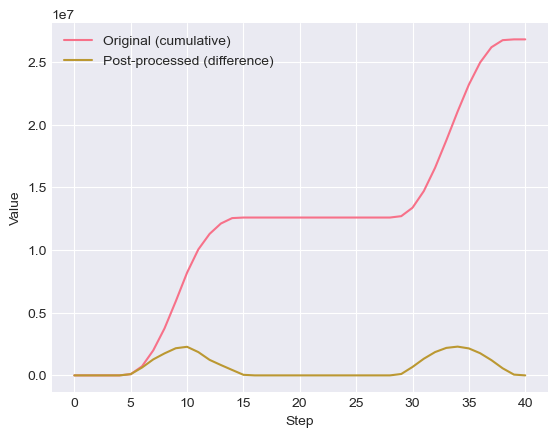

In [143]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(target_data, label="Original (cumulative)")
plt.plot(df_post_processed, label="Post-processed (difference)")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Value")
plt.show()


In [ ]:

# TODO Identify the accumulation period ( 1 hour = 3600 seconds), and convert J/m²  to Wh/m² 
# Hint: ssrd_wm2 = ssrd_jm2 / accumulation_period_seconds

forecast_df_Wh = df_post_processed / 3600

In [172]:
forecast_df_Wh = pd.Series([
    0.0, 0.0, 0.0, 0.0, 0.0,
    26.797778, 173.087222, 353.966667, 487.131111, 601.560556,
    633.328889, 515.965, 343.603889, 229.516667, 120.198889,
    12.550556, -0.000556, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0,
    30.558889, 186.904444, 368.331111, 516.265556, 609.151111,
    637.183333, 597.505556, 490.967778, 337.443333, 156.58,
    17.237778, 0.0
])


## Prepare Training and Test Sets

### 📝 Split data for training

Create train/validation/test splits. For time series, we should use temporal splits (not random).

In [ ]:
# TODO: Define feature columns (all CAMS variables?)
feature_cols = None  # TODO: All columns except power_production

# TODO: Define target column
target_col = None  # TODO: power_production column name

# TODO: Split data temporally (e.g., 70% train, 15% validation, 15% test)
#train_size = int(0.70 * len(training_data))
#val_size = int(0.15 * len(training_data))

# TODO: Create train, validation, and test sets
train_data = None
val_data = None
test_data = None

In [150]:
training_data.columns

Index(['Observation period', 'TOA', 'Clear sky GHI', 'Clear sky BHI',
       'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI', 'BNI',
       'Reliability', 'timestamp', 'power_kw'],
      dtype='object')

In [ ]:
# SOLUTION
power_col = [col for col in training_data.columns if 'power' in col.lower() or 'production' in col.lower()][0]
feature_cols = [col for col in training_data.columns if col != power_col]
feature_cols = feature_cols[1:-3]
target_col = power_col

print(f"Feature columns ({training_data.shape[1]}): {feature_cols}")
print(f"Target column: {target_col}")

# Temporal split (chronological, not random!)
train_size = int(0.70 * training_data.shape[0])
val_size = int(0.15 * training_data.shape[0])
test_size = training_data.shape[0] - train_size - val_size

train_data = training_data.iloc[:train_size]
val_data = training_data.iloc[train_size:train_size+val_size]
test_data = training_data.iloc[train_size+val_size:]

print("\nData Split Summary:")
print("=" * 80)
print(f"Training set:   {train_data.shape[0]:,} samples ({training_data.shape[0]/24:.1f} days) - {train_data.index.min()} to {train_data.index.max()}")
print(f"Validation set: {val_data.shape[0]:,} samples ({val_data.shape[0]/24:.1f} days) - {val_data.index.min()} to {val_data.index.max()}")
print(f"Test set:       {test_data.shape[0]:,} samples ({test_data.shape[0]/24:.1f} days) - {test_data.index.min()} to {test_data.index.max()}")

# Extract X and y for each set
X_train = train_data[feature_cols].values
y_train = train_data[target_col].values

X_val = val_data[feature_cols].values
y_val = val_data[target_col].values

X_test = test_data[feature_cols].values
y_test = test_data[target_col].values

print("\nArray shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

print("\n✓ Data split into train/validation/test sets")

Feature columns (13): ['TOA', 'Clear sky GHI', 'Clear sky BHI', 'Clear sky DHI', 'Clear sky BNI', 'GHI', 'BHI', 'DHI']
Target column: power_kw

Data Split Summary:
Training set:   30,693 samples (1827.0 days) - 2020-12-06 00:00:00 to 2024-06-06 20:00:00
Validation set: 6,577 samples (274.0 days) - 2024-06-06 21:00:00 to 2025-03-07 21:00:00
Test set:       6,578 samples (274.1 days) - 2025-03-07 22:00:00 to 2025-12-06 23:00:00

Array shapes:
X_train: (30693, 8), y_train: (30693,)
X_val: (6577, 8), y_val: (6577,)
X_test: (6578, 8), y_test: (6578,)

✓ Data split into train/validation/test sets


### 📝 Scale features

Scale features for machine learning models.

In [156]:
# TODO: Fit scaler on training data only
scaler = StandardScaler()
# TODO: scaler.fit(X_train)

# TODO: Transform all sets
X_train_scaled = None  # TODO
X_val_scaled = None  # TODO
X_test_scaled = None  # TODO

In [157]:
# SOLUTION
# Fit scaler on training data ONLY (avoid data leakage)
scaler = StandardScaler()

scaler.fit(X_train)

# Transform all sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Also scale target for neural network (optional but often helps)
scaler_y = StandardScaler()
scaler_y.fit(y_train.reshape(-1, 1))

y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("✓ Features and target scaled using StandardScaler")
print(f"\nScaled feature means (should be ~0): {X_train_scaled.mean(axis=0)[:5]}...")
print(f"Scaled feature stds (should be ~1): {X_train_scaled.std(axis=0)[:5]}...")

✓ Features and target scaled using StandardScaler

Scaled feature means (should be ~0): [ 7.40799777e-18 -8.33399749e-17 -5.18559844e-17  4.62999860e-17
  1.11119966e-17]...
Scaled feature stds (should be ~1): [1. 1. 1. 1. 1.]...


## Build Regression Models for solar power forecasting

Now we'll build 2 different forecasting approaches:
1. Neural Network
2. XGBoost

### Method 1: Neural Network

### 📝Build and train neural network

In [158]:
# TODO: Build a simple neural network
# Architecture: Input -> Hidden(64, ReLU) -> Hidden(32, ReLU) -> Output

model_nn = keras.Sequential([
    # TODO: Add layers
])

# TODO: Compile model
model_nn.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

#model_nn.summary()

In [173]:
np.array(feature_cols).shape[0]

8

In [164]:
# SOLUTION
model_nn = keras.Sequential([
    layers.Input(shape=(np.array(feature_cols).shape[0],)),
    #layers.Dense(64, activation='relu', name='hidden1'),
    #layers.Dropout(0.2),
    layers.Dense(32, activation='relu', name='hidden2'),
    layers.Dense(1, name='output')
])

model_nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("Neural Network Architecture:")
print("=" * 80)
model_nn.summary()
print("=" * 80)
print("\n✓ Neural network model built")

Neural Network Architecture:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden2 (Dense)             (None, 32)                288       
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

✓ Neural network model built


In [ ]:
# TODO: Train the model
history_nn = model_nn.fit(
    # TODO: Add training parameters
    epochs=50,
    batch_size=128,
    validation_data=(X_val_scaled, y_val_scaled),
    verbose=1
)

print("\n✓ Neural network trained")

Training Neural Network...
Epoch 1/50
1919/1919 [==============================] - 7s 3ms/step - loss: 0.0216 - mae: 0.0707 - val_loss: 0.0062 - val_mae: 0.0496 - lr: 0.0010
Epoch 2/50
1919/1919 [==============================] - 6s 3ms/step - loss: 0.0067 - mae: 0.0514 - val_loss: 0.0060 - val_mae: 0.0494 - lr: 0.0010
Epoch 3/50
1919/1919 [==============================] - 5s 3ms/step - loss: 0.0065 - mae: 0.0510 - val_loss: 0.0064 - val_mae: 0.0531 - lr: 0.0010
Epoch 4/50
1919/1919 [==============================] - 6s 3ms/step - loss: 0.0065 - mae: 0.0508 - val_loss: 0.0060 - val_mae: 0.0475 - lr: 0.0010
Epoch 5/50
1919/1919 [==============================] - 6s 3ms/step - loss: 0.0064 - mae: 0.0507 - val_loss: 0.0059 - val_mae: 0.0487 - lr: 0.0010
Epoch 6/50
1919/1919 [==============================] - 6s 3ms/step - loss: 0.0065 - mae: 0.0505 - val_loss: 0.0059 - val_mae: 0.0479 - lr: 0.0010
Epoch 7/50
1919/1919 [==============================] - 6s 3ms/step - loss: 0.0064 - mae: 0

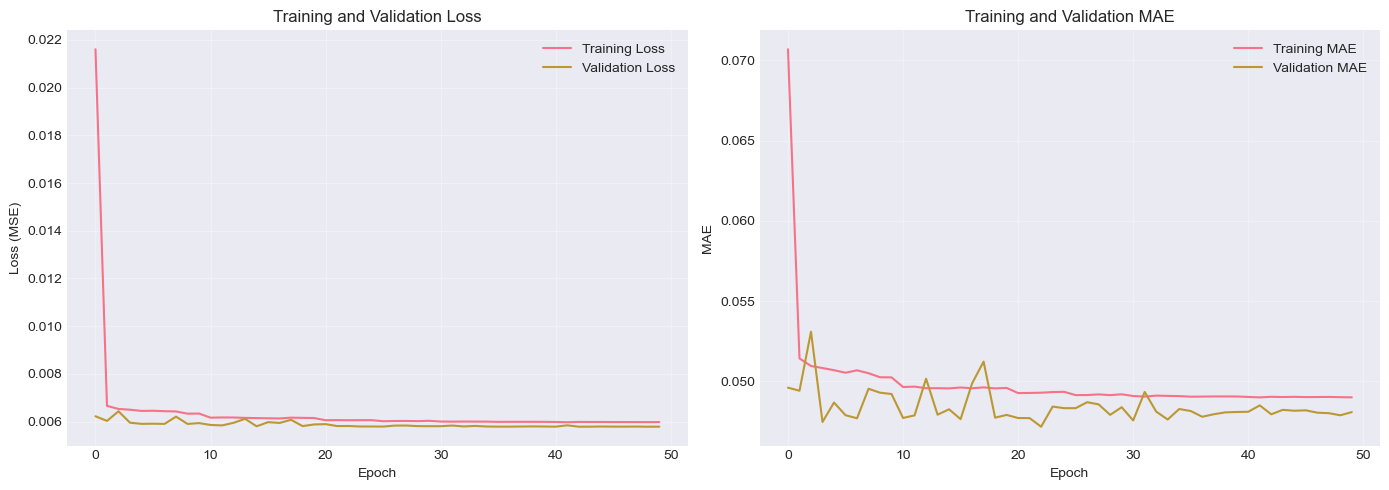


Neural Network Performance:
RMSE: 238.929 W/m²
MAE:  152.415 W/m²
R²:   0.9937

✓ Neural network trained and evaluated


In [165]:
# SOLUTION
print("Training Neural Network...")
print("=" * 80)

history_nn = model_nn.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, monitor='val_loss')
    ]
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_nn.history['loss'], label='Training Loss')
axes[0].plot(history_nn.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_nn.history['mae'], label='Training MAE')
axes[1].plot(history_nn.history['val_mae'], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Make predictions and evaluate
y_pred_nn_scaled = model_nn.predict(X_test_scaled, verbose=0)
y_pred_nn = scaler_y.inverse_transform(y_pred_nn_scaled).flatten()

rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("\nNeural Network Performance:")
print("=" * 80)
print(f"RMSE: {rmse_nn:.3f} W/m²")
print(f"MAE:  {mae_nn:.3f} W/m²")
print(f"R²:   {r2_nn:.4f}")
print("=" * 80)

print("\n✓ Neural network trained and evaluated")

### Method 2: XGBoost

### 📝 Build and train XGBoost model

In [174]:
# TODO: Create XGBoost regressor
model_xgb = xgb.XGBRegressor(
    # TODO: Set hyperparameters
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# TODO: Train the model
# model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

print("\n✓ XGBoost model trained")


✓ XGBoost model trained


Training XGBoost Model...
[0]	validation_0-rmse:2464.82382


c:\Users\ageor\miniconda3\envs\DRE\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-rmse:214.84199
[83]	validation_0-rmse:215.26294

XGBoost Performance:
RMSE: 241.502 W/m²
MAE:  154.252 W/m²
R²:   0.9936


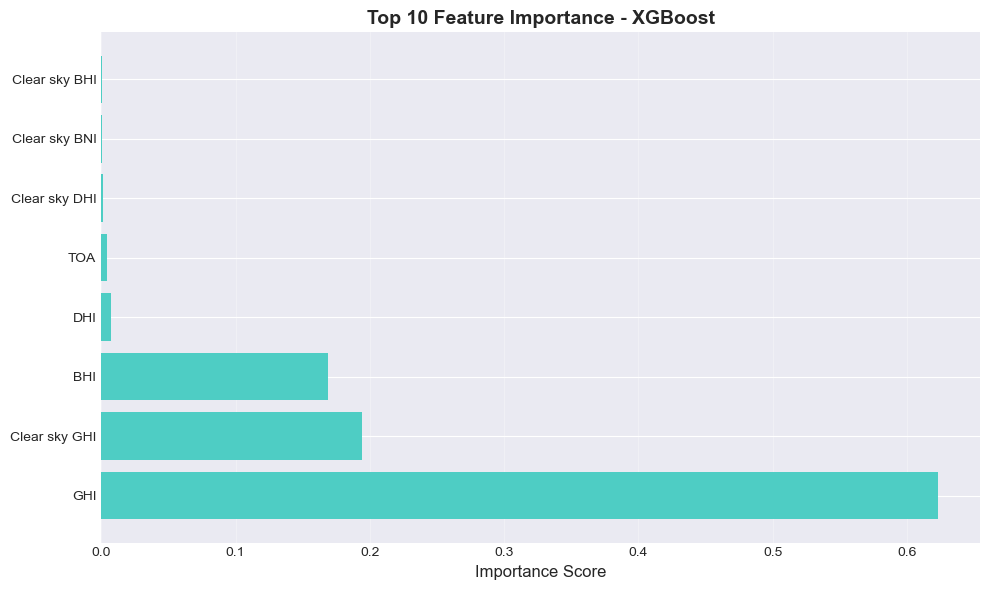


✓ XGBoost model trained and evaluated


In [175]:
# SOLUTION
print("Training XGBoost Model...")
print("=" * 80)

model_xgb = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train with early stopping
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=20,
    verbose=50
)

# Make predictions
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Performance:")
print("=" * 80)
print(f"RMSE: {rmse_xgb:.3f} W/m²")
print(f"MAE:  {mae_xgb:.3f} W/m²")
print(f"R²:   {r2_xgb:.4f}")
print("=" * 80)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10], color='#4ECDC4')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n✓ XGBoost model trained and evaluated")

## Model Comparison and Evaluation

### 📝 Compare all different methods

In [177]:
# TODO: Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Method': ['Neural Network', 'XGBoost'],
    'RMSE': [None, None],  # TODO: Fill in
    'MAE': [None, None],   # TODO: Fill in
    'R²': [None, None]     # TODO: Fill in
})

print(comparison_df)

           Method  RMSE   MAE    R²
0  Neural Network  None  None  None
1         XGBoost  None  None  None



MODEL COMPARISON SUMMARY
        Method  RMSE (W/m²)  MAE (W/m²)       R²
Neural Network   238.928881  152.414665 0.993705
       XGBoost   241.501717  154.251929 0.993569

Best RMSE: Neural Network (238.929)
Best MAE: Neural Network (152.415)
Best R²: Neural Network (0.9937)


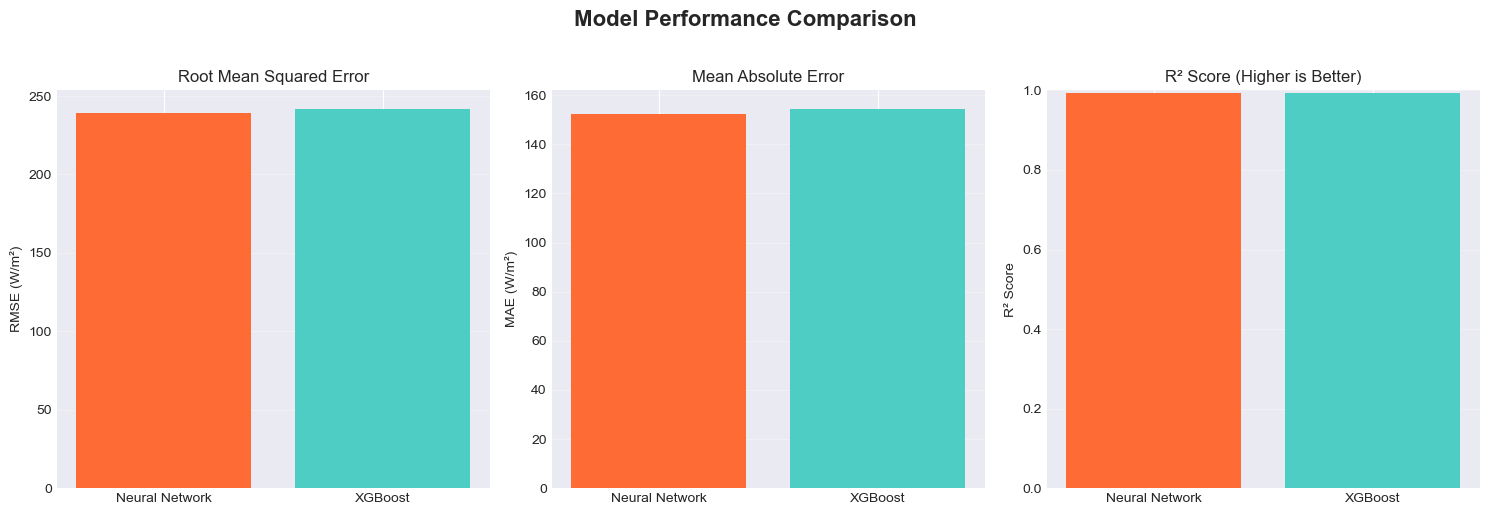


✓ Model comparison complete


In [178]:
# SOLUTION
comparison_df = pd.DataFrame({
    'Method': [ 'Neural Network', 'XGBoost'],
    'RMSE (W/m²)': [ rmse_nn, rmse_xgb],
    'MAE (W/m²)': [ mae_nn, mae_xgb],
    'R²': [ r2_nn, r2_xgb]
})

# Highlight best performance
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Find best model
best_rmse_idx = comparison_df['RMSE (W/m²)'].idxmin()
best_mae_idx = comparison_df['MAE (W/m²)'].idxmin()
best_r2_idx = comparison_df['R²'].idxmax()

print(f"\nBest RMSE: {comparison_df.loc[best_rmse_idx, 'Method']} ({comparison_df.loc[best_rmse_idx, 'RMSE (W/m²)']:.3f})")
print(f"Best MAE: {comparison_df.loc[best_mae_idx, 'Method']} ({comparison_df.loc[best_mae_idx, 'MAE (W/m²)']:.3f})")
print(f"Best R²: {comparison_df.loc[best_r2_idx, 'Method']} ({comparison_df.loc[best_r2_idx, 'R²']:.4f})")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE
axes[0].bar(comparison_df['Method'], comparison_df['RMSE (W/m²)'], color=['#FF6B35', '#4ECDC4', '#95E1D3'])
axes[0].set_ylabel('RMSE (W/m²)')
axes[0].set_title('Root Mean Squared Error')
axes[0].grid(True, alpha=0.3, axis='y')

# MAE
axes[1].bar(comparison_df['Method'], comparison_df['MAE (W/m²)'], color=['#FF6B35', '#4ECDC4', '#95E1D3'])
axes[1].set_ylabel('MAE (W/m²)')
axes[1].set_title('Mean Absolute Error')
axes[1].grid(True, alpha=0.3, axis='y')

# R²
axes[2].bar(comparison_df['Method'], comparison_df['R²'], color=['#FF6B35', '#4ECDC4', '#95E1D3'])
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Score (Higher is Better)')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Model comparison complete")

### 📝 Visual comparison on test set

In [65]:
# TODO: Create a time series plot comparing actual vs predicted for all three methods
# Show a sample period (e.g., 7 days from test set)

# Your visualization code here

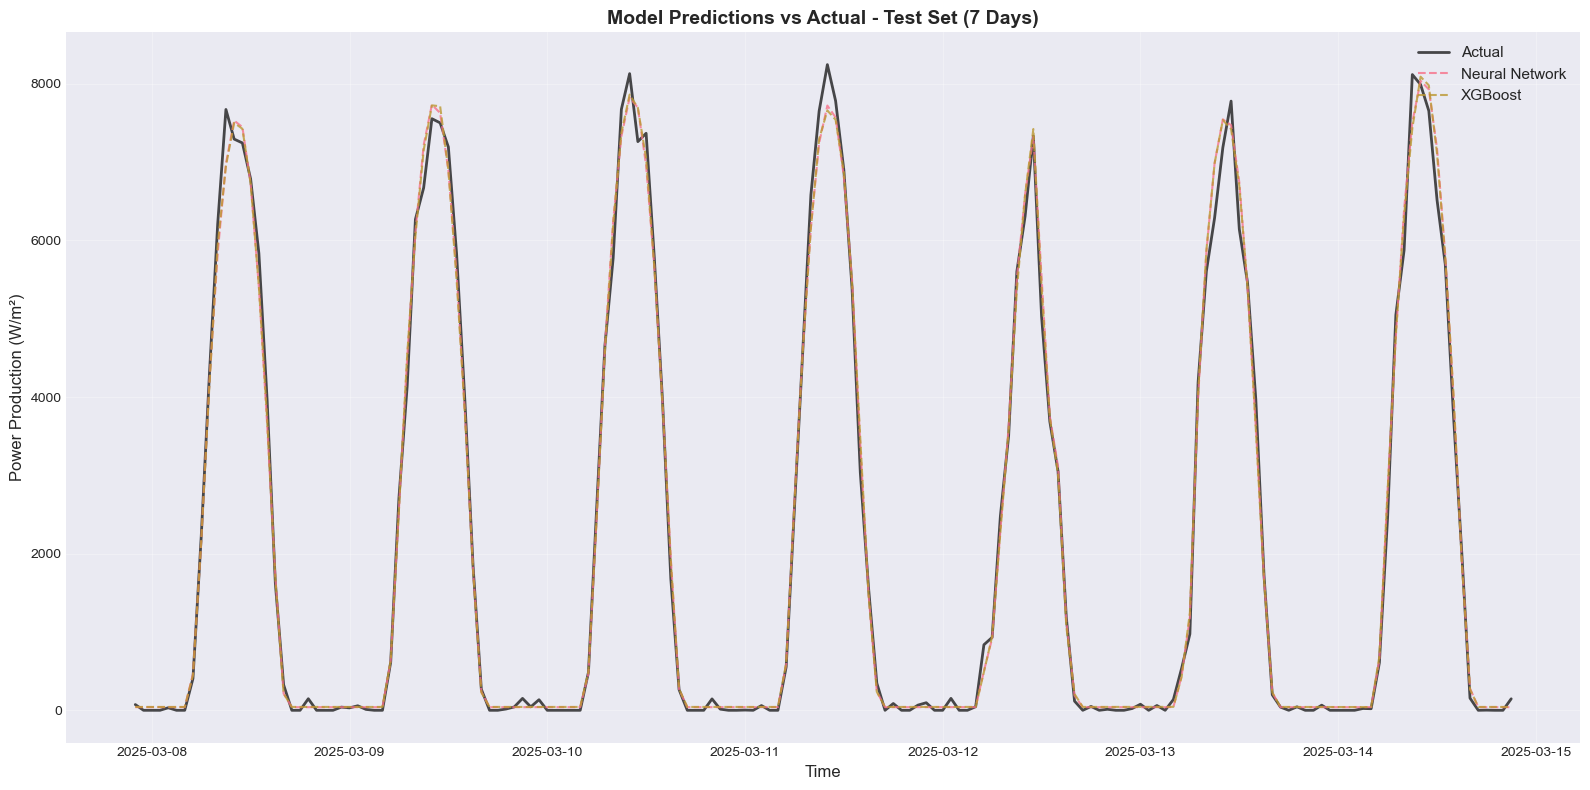

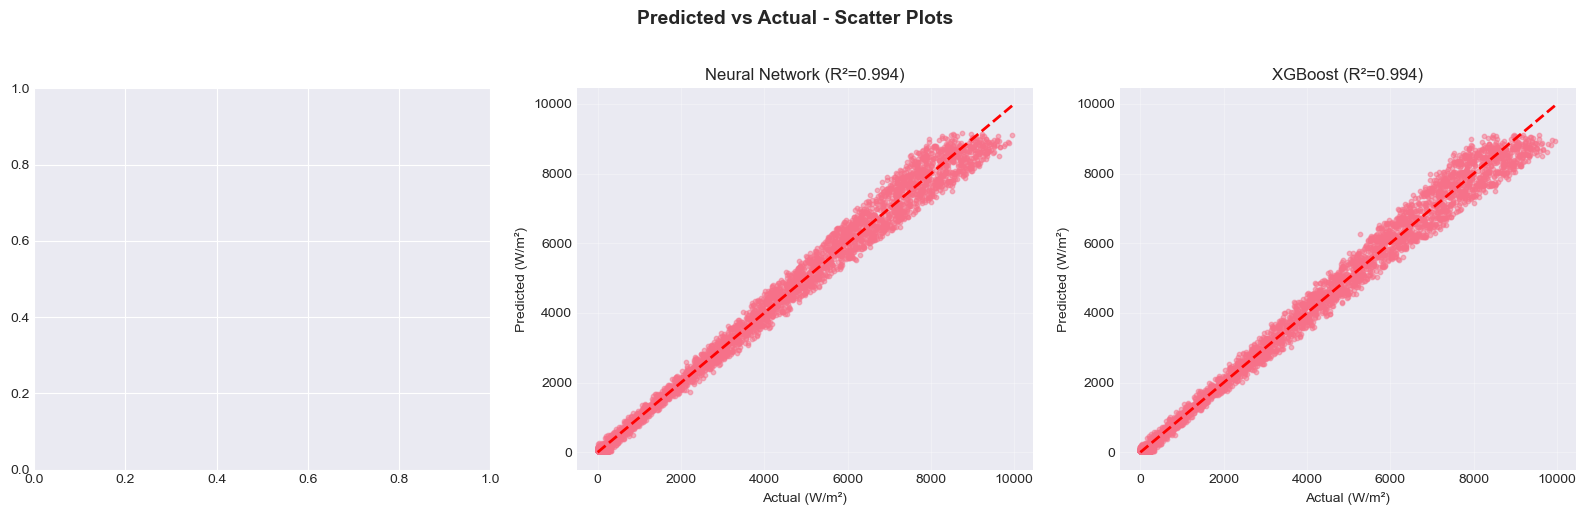


✓ Visual comparison complete


In [179]:
# SOLUTION
# Select a sample period from test set (e.g., first 7 days)
sample_size = 24 * 7  # 7 days
sample_timestamps = test_data.index[:sample_size]
sample_actual = y_test[:sample_size]
sample_nn = y_pred_nn[:sample_size]
sample_xgb = y_pred_xgb[:sample_size]

# Create visualization
plt.figure(figsize=(16, 8))

plt.plot(sample_timestamps, sample_actual, label='Actual', linewidth=2, color='black', alpha=0.7)
plt.plot(sample_timestamps, sample_nn, label='Neural Network', linewidth=1.5, linestyle='--', alpha=0.8)
plt.plot(sample_timestamps, sample_xgb, label='XGBoost', linewidth=1.5, linestyle='--', alpha=0.8)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Power Production (W/m²)', fontsize=12)
plt.title('Model Predictions vs Actual - Test Set (7 Days)', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Neural Network
axes[1].scatter(y_test, y_pred_nn, alpha=0.5, s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual (W/m²)')
axes[1].set_ylabel('Predicted (W/m²)')
axes[1].set_title(f'Neural Network (R²={r2_nn:.3f})')
axes[1].grid(True, alpha=0.3)

# XGBoost
axes[2].scatter(y_test, y_pred_xgb, alpha=0.5, s=10)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual (W/m²)')
axes[2].set_ylabel('Predicted (W/m²)')
axes[2].set_title(f'XGBoost (R²={r2_xgb:.3f})')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Predicted vs Actual - Scatter Plots', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Visual comparison complete")


## Apply to ECMWF Forecast

### 📝 Use models to forecast next 2 days

Apply your trained models to the ECMWF forecast data.

In [180]:
# TODO: Prepare forecast features from ECMWF data
# Note: ECMWF forecast may have different/fewer features than training data
# You may need to use only GHI (SSRD) or engineer features

if forecast_df_Wh is not None:
    # TODO: Make predictions with all three models
    forecast_physics = None  # TODO
    forecast_nn = None  # TODO
    forecast_xgb = None  # TODO
    
    print("2-day forecast complete")
else:
    print("Skipping forecast - GRIB file not loaded")

2-day forecast complete


# SOLUTION
if forecast_df_Wh is not None:
    print("Generating 2-Day Power Forecast...")
    print("=" * 80)
    

    # For ML models, we need to prepare features
    # If we only have SSRD, we'll need to either:
    # 1. Use a simpler model trained only on GHI
    # 2. Engineer features or use average values for missing features
    # 3. Retrain models with only available forecast features
    
    # Option 2: Fill missing features with historical averages for the same hours
    forecast_features = pd.DataFrame(index=forecast_df_Wh.index)
    
    # Use SSRD as GHI
    ghi_col_name = [col for col in feature_cols if 'ghi' in col.lower()][0]
    forecast_features[ghi_col_name] = ssrd_values
    
    # Fill other features with seasonal/hourly averages from training data
    for col in feature_cols:
        if col not in forecast_features.columns:
            # Use hour-of-day average from training data
            hourly_avg = train_data.groupby(train_data.index.hour)[col].mean()
            forecast_features[col] = forecast_features.index.hour.map(hourly_avg)
    
    # Ensure column order matches training
    forecast_features = forecast_features[feature_cols]
    
    # Scale features
    X_forecast = forecast_features.values
    X_forecast_scaled = scaler.transform(X_forecast)
    
    # Neural Network forecast
    forecast_nn_scaled = model_nn.predict(X_forecast_scaled, verbose=0)
    forecast_nn = scaler_y.inverse_transform(forecast_nn_scaled).flatten()
    forecast_nn = np.maximum(forecast_nn, 0)  # Ensure non-negative
    
    # XGBoost forecast
    forecast_xgb = model_xgb.predict(X_forecast)
    forecast_xgb = np.maximum(forecast_xgb, 0)  # Ensure non-negative
    
    # Create forecast DataFrame
    forecast_results = pd.DataFrame({
        'timestamp': forecast_df.index,
        'ssrd_forecast': ssrd_values,
        'power_physics': forecast_physics,
        'power_nn': forecast_nn,
        'power_xgb': forecast_xgb
    }).set_index('timestamp')
    
    # Visualize 2-day forecast
    plt.figure(figsize=(14, 6))
    plt.plot(forecast_results.index, forecast_results['power_physics'], 
             label='Physics-Based', linewidth=2, marker='o', markersize=4)
    plt.plot(forecast_results.index, forecast_results['power_nn'], 
             label='Neural Network', linewidth=2, marker='s', markersize=4)
    plt.plot(forecast_results.index, forecast_results['power_xgb'], 
             label='XGBoost', linewidth=2, marker='^', markersize=4)
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Forecasted Power (W/m²)', fontsize=12)
    plt.title('2-Day Power Production Forecast - All Methods', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nForecast Summary:")
    print("=" * 80)
    for method in ['physics', 'nn', 'xgb']:
        col = f'power_{method}'
        total_energy = forecast_results[col].sum()  # Total Wh/m² over forecast period
        peak_power = forecast_results[col].max()
        print(f"{method.upper():15} - Total Energy: {total_energy:,.0f} Wh/m², Peak: {peak_power:.1f} W/m²")
    print("=" * 80)
    
    display(forecast_results)
    
    print("\n✓ 2-day forecast generated with all methods")
else:
    print("⚠ Skipping forecast - GRIB file not loaded")

## Part 10: Discussion and Reflection

### 📝 DISCUSSION QUESTIONS

1. **Which model performed best on the test set? Why do you think this is?**

   *Your answer:*

2. **How did the methods compare in terms of computational cost vs accuracy?**

   *Your answer:*

3. **What are the main advantages and disadvantages of each approach?**

   - Neural Network:
   - XGBoost:

4. **Which features were most important for the ML models? Does this align with physical intuition?**

   *Your answer:*

5. **How would you improve each model if given more time and resources?**

   *Your answer:*

6. **In a production environment, which model would you deploy and why?**

   *Your answer:*

7. **How could you create an ensemble model combining all three approaches?**

   *Your answer:*

## Summary

**Congratulations!** You've completed a comprehensive solar power forecasting exercise using real data.

### What you learned:
✅ Load and process real CAMS historical data  
✅ Perform EDA: statistics, correlations, feature engineering  
✅ Handle GRIB forecast files from ECMWF  
✅ Build three different forecasting approaches  
✅ Compare models quantitatively and visually  
✅ Generate operational forecasts  

### Next steps:
- Try ensemble methods
- Add weather uncertainty
- Explore deep learning architectures (LSTM, Transformers)
- Deploy as a real-time forecasting service

🌱⚡ **Keep building renewable energy solutions!**